# Attribute

**Direct Reference**: pinn_ode_tutorial-master github repositor

**Original Work**: *Renato Nascimento, Kajetan Fricke, Felipe Viana*
**Reference Github repo** https://github.com/PML-UCF/pinn_ode_tutorial.git

# Libraries and Dependencies

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as matplotlib

from torch.nn.parameter import Parameter
from torch import (
    linalg,
    nn,
    Tensor,
    stack,
    cat,
    transpose, 
    optim,
    zeros,
    diag,
    reshape,
    rand
    )

#For Data Generation
from scipy import signal
from scipy import linalg as linalg2

# Underlying Model and Training Dataset

In [2]:
# Mass, stiffness and damping matrices
m1 = 20.0
m2 = 10.0

k1 = 2e3
k2 = 1e3
k3 = 5e3

c1 = 100.0
c2 = 110.0
c3 = 120.0

Mvib = np.asarray([[m1, 0.0], [0.0, m2]], dtype = float)
Cvib = np.asarray([[c1+c2, -c2], [-c2, c2+c3]], dtype = float) 
Kvib = np.asarray([[k1+k2, -k2], [-k2, k2+k3]], dtype = float)

#--------------------------------------------------------------------------
# building matrices in continuous time domain
n = Mvib.shape[0]
I = np.eye(n)
Z = np.zeros([n,n])
Minv = linalg2.pinv(Mvib)

negMinvK = - np.matmul(Minv, Kvib)
negMinvC = - np.matmul(Minv, Cvib)

Ac = np.hstack((np.vstack((Z,negMinvK)), np.vstack((I,negMinvC))))
Bc = np.vstack((Z,Minv))
Cc = np.hstack((I,Z))
Dc = Z.copy()

systemC = (Ac, Bc, Cc, Dc)
#print(systemC)

#--------------------------------------------------------------------------
# building matrices in discrete time domain
t = np.linspace(0, 1,501,dtype = float)
dt = t[1] - t[0]

sD = signal.cont2discrete(systemC, dt)

Ad = sD[0]
Bd = sD[1]
Cd = sD[2]
Dd = sD[3]

systemD = (Ad, Bd, Cd, Dd, dt)

#--------------------------------------------------------------------------
u = np.zeros((t.shape[0], n))
u[:, 1] = 3*np.ones((t.shape[0],))
u[:, 0] = 2*np.ones((t.shape[0],))

x0 = np.zeros((Ad.shape[1],), dtype = 'float32')
x0[0] = 0.0005

output = signal.dlsim(systemD, u = u, t = t, x0 = x0)
yScipy = output[1]

yTarget = yScipy + 1e-4*np.random.randn(yScipy.shape[0], yScipy.shape[1])

#store unpreterbed time
t_store = t

# Hybrid RNN Code

### Construct / Deploy Hybrid RNN

In [3]:
class MyRNN(nn.Module):
    def __init__(self, cell, **kwargs):
        super(MyRNN, self).__init__()
        self.cell = cell

    def forward(self, inputs, initial_state):
        # Step into proceeding timestep
        bs, seq_sz, _ = inputs.shape
        state = []
        state.append(initial_state)
        for t in range(1, seq_sz): 
            input = inputs[:, t-1, :]
            state_t = self.cell.forward(input, state[t-1])
            state.append(state[t-1]+state_t)

        return stack((state),dim=1)

### Construct Runge-Kutta Cell

In [4]:
class RungeKuttaIntegratorCell(nn.Module):
    def __init__(self, m, c, k, dt, **kwargs):
        super(RungeKuttaIntegratorCell, self).__init__(**kwargs)
        self.Minv = linalg.inv(diag(m))
        self.c1 = Parameter(c[0])
        self.c2 = Parameter(c[1])
        self.c3 = Parameter(c[2])
        
        self.K    = Tensor([[k[0]+k[1],-k[1]],[-k[1],k[1]+k[2]]])
        # Runge-Kutta iterative vectors
        self.state_size    = 2*len(m)
        self.A  = Tensor([0., 0.5, 0.5, 1.0])
        self.B  = Tensor([[1/6, 2/6, 2/6, 1/6]])
        self.dt = dt
        
    def forward(self, inputs, states):
        C = stack((stack((self.c1+self.c2, -self.c2)), stack((-self.c2, self.c2+self.c3))))
        y    = states[:, :2]
        ydot = states[:, 2:]
        #Prepare Runge-Kutta computation
        yddoti = self._fun(self.Minv, self.K, C, inputs, y, ydot)
        yi     = y + self.A[0] * ydot * self.dt
        ydoti  = ydot + self.A[0] * yddoti * self.dt
        fn     = self._fun(self.Minv, self.K, C, inputs, yi, ydoti)
        #Perfom Runge-Kutta Computation
        for j in range(1,4):
            yn    = y + self.A[j] * ydot * self.dt
            ydotn = ydot + self.A[j] * yddoti * self.dt
            ydoti = cat([ydoti, ydotn], dim=0)
            fn    = cat([fn, self._fun(self.Minv, self.K, C, inputs, yn, ydotn)], dim=0)

        y    = linalg.matmul(self.B, ydoti) * self.dt
        ydot =  linalg.matmul(self.B, fn) * self.dt

        return cat(([y, ydot]), dim=-1)

    def _fun(self, Minv, K, C, u, y, ydot):
        return linalg.matmul(u - linalg.matmul(ydot, transpose(C, 0, 1)) - linalg.matmul(y, transpose (K, 0, 1)), transpose(Minv, 0, 1))


### Training Loop

In [5]:
def pinn_training_loop(n_epochs, optimizer, model, loss_fn, train, label, initial_state):
    mae = nn.L1Loss()
    losses = []
    c1s = []
    c2s = []
    c3s = []
    for epoch in range(1, n_epochs + 1):
        #Forward pass
        output_train = model(train, initial_state)
        #Partial observation
        loss_train = loss_fn(output_train[:,:,0:1], label)
        mae_train = mae(output_train[:,:,0:1], label)
        #Track loss and c changes
        losses.append(loss_train.item())
        c1s.append(c[0].item())
        c2s.append(c[1].item())
        c3s.append(c[2].item())
        #Backward pass
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        print(f"Epoch {epoch}, Training loss {loss_train.item():.4e}, mae {mae_train.item():.4e}")
        
    return losses, c1s, c2s, c3s

### Execute Training

In [6]:
# masses, spring coefficients, and damping coefficients
m = Tensor([20.0, 10.0])
k = Tensor([2e3, 1e3, 5e3])
#c = 1000*rand(3) # initial guess for damping coefficient. Between 0 and 1000
c = Tensor([10.0, 10.0, 10.0])

# data
dt = (t_store[1] - t_store[0])
t = Tensor(t_store)
utrain = Tensor(u)
ytrain = Tensor(yTarget)

#resize tensors
t = reshape(t,(len(t),1))
ufull = reshape(utrain, (1, len(t_store), 2))
yfull = reshape(ytrain, (1, len(t_store), 2))
utrain = ufull[:,0:126,:]
ytrain = yfull[:,0:126,:]
t_train = t[0:126,:]
ytrain_partial = ytrain[:,:,0:1]
yfull_partial = yfull[:,:,0:1]

# Initial state of the system 
initial_state = zeros((1,2 * len(m)))
initial_state[0,0] = 0.0005

rkCell = RungeKuttaIntegratorCell(m=m, c=c, k=k, dt=dt)
model = MyRNN(cell=rkCell)
    
#prediction results before training
yPred_before = model(ufull, initial_state)[0, :, :]
yPred_before = yPred_before.detach().numpy()[:,:2]

#check number of params
total_params = sum(p.numel() for p in model.parameters())
print(total_params)

#PINN training
losses, c1s, c2s, c3s = pinn_training_loop(
        n_epochs = 900,
        optimizer = optim.Adam(model.parameters(), lr=5e2),
        model = model,
        loss_fn = nn.MSELoss(),
        train = utrain,
        label = ytrain_partial,
        initial_state=initial_state
        )
#print("debug stopper")

3
Epoch 1, Training loss 1.9966e-08, mae 1.0955e-04
Epoch 2, Training loss 1.7753e-08, mae 1.0515e-04
Epoch 3, Training loss 1.6129e-08, mae 1.0169e-04
Epoch 4, Training loss 1.4923e-08, mae 9.8991e-05
Epoch 5, Training loss 1.4018e-08, mae 9.6737e-05
Epoch 6, Training loss 1.3331e-08, mae 9.4900e-05
Epoch 7, Training loss 1.2805e-08, mae 9.3276e-05
Epoch 8, Training loss 1.2396e-08, mae 9.1897e-05
Epoch 9, Training loss 1.2076e-08, mae 9.0682e-05
Epoch 10, Training loss 1.1820e-08, mae 8.9587e-05
Epoch 11, Training loss 1.1614e-08, mae 8.8598e-05
Epoch 12, Training loss 1.1446e-08, mae 8.7700e-05
Epoch 13, Training loss 1.1306e-08, mae 8.6889e-05
Epoch 14, Training loss 1.1187e-08, mae 8.6262e-05
Epoch 15, Training loss 1.1086e-08, mae 8.5716e-05
Epoch 16, Training loss 1.0998e-08, mae 8.5252e-05
Epoch 17, Training loss 1.0920e-08, mae 8.4829e-05
Epoch 18, Training loss 1.0851e-08, mae 8.4433e-05
Epoch 19, Training loss 1.0790e-08, mae 8.4062e-05
Epoch 20, Training loss 1.0734e-08, ma

### Visualize Results

tensor([115.5107, 132.0502,  90.3828])


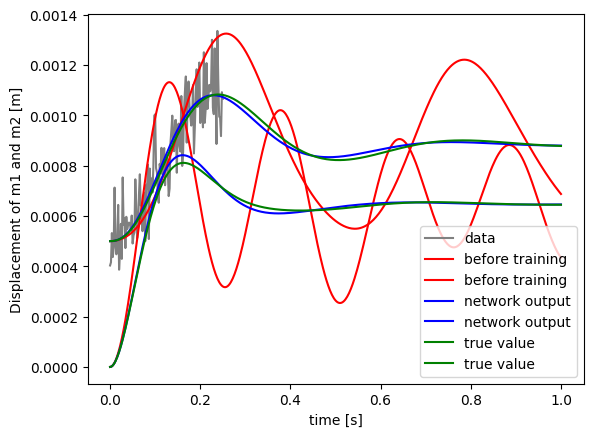

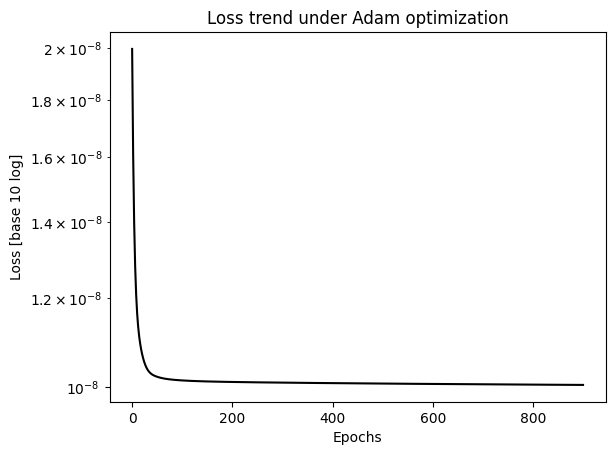

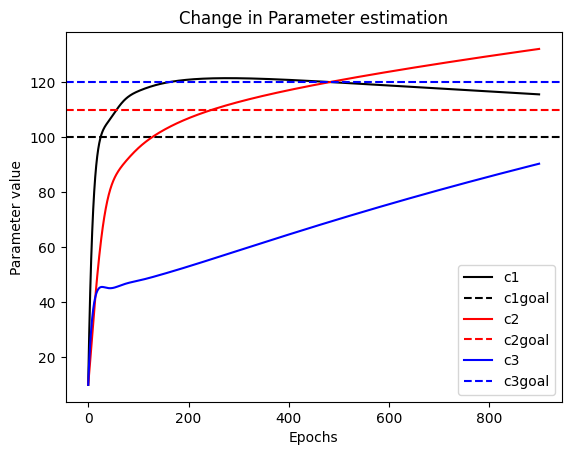

In [7]:
#prediction results after training
yPred = model(ufull, initial_state) [0, :, :]
yPred = yPred.detach().numpy()[:,:2]

# plotting prediction results
print(c)
plt.plot(t[0:126], ytrain[0, :, 0:1], 'gray', label = 'data')
plt.plot(t, yPred_before, 'r', label='before training')
plt.plot(t, yPred, 'b', label='network output')
plt.plot(t, yScipy, 'g', label = 'true value')
plt.xlabel('time [s]')
plt.ylabel('Displacement of m1 and m2 [m]')
plt.legend()
plt.show()


# Loss
plt.plot(losses,color = 'black')
plt.yscale("log")
plt.title("Loss trend under Adam optimization")
plt.xlabel('Epochs')
plt.ylabel('Loss [base 10 log]')
plt.show()

#C track
plt.plot(c1s[0:], color = 'black', label = 'c1')
plt.axhline(y = 100, color = 'black', linestyle = 'dashed', label = 'c1goal')
plt.plot(c2s[0:], color = 'red', label = 'c2')
plt.axhline(y = 110, color = 'red', linestyle = 'dashed', label = 'c2goal')
plt.plot(c3s[0:], color = 'blue', label = 'c3')
plt.axhline(y = 120, color = 'blue', linestyle = 'dashed', label = 'c3goal')
plt.legend()
plt.title('Change in Parameter estimation')
plt.xlabel('Epochs')
plt.ylabel('Parameter value')
plt.show()